## Customer Churn Prediction

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [8]:
# load the data
data = pd.read_csv('Telco-Customer-Churn.csv') 
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data Preparation based on EDA

In [9]:

def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

In [10]:
df = datapreparation(filepath = "Telco-Customer-Churn.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [11]:
df.isnull().any().any()

False

### Building the model

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
#from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [14]:
train, test = train_test_split(df, test_size=0.2, random_state=111, stratify = df.Churn)

In [15]:
x = df.columns[df.columns!="Churn"]
y = "Churn"
train_x = train[x]
train_y = train[y]
test_x = test[x]
test_y = test[y]

In [16]:
#function for model fitting
def churn_prediction(algo, training_x, training_y, testing_x, testing_y, cols, cf = 'coefficients'):
    algo.fit(training_x,training_y)
    predictions = algo.predict(testing_x)
    probabilities = algo.predict_proba(testing_x)[:,1]
    
    #coeffs
    if cf == "coefficients":
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif cf == "features":
        coefficients = pd.DataFrame(algo.feature_importances_)
        
    column_df = pd.DataFrame(cols)
    coef_sumry = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algo)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,probabilities) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities)
    
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    plt.subplot(212)
    sns.barplot(x = coef_sumry["features"] ,y = coef_sumry["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation="vertical")
    
    plt.show()


In [17]:
param_grid1 = {'max_features':['auto', 'sqrt', 'log2', None],
          'n_estimators':[300, 500, 700, 900, 1100, 1300]
         }

rf_model = RandomForestClassifier()
grid1 = GridSearchCV(estimator=rf_model, param_grid=param_grid1, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid1.fit(train_x, train_y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [300, 500, 700, 900, 1100, 1300]},
             scoring='f1', verbose=1)

In [18]:
grid1.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=1100)

<AxesSubplot:xlabel='param_max_features', ylabel='param_n_estimators'>

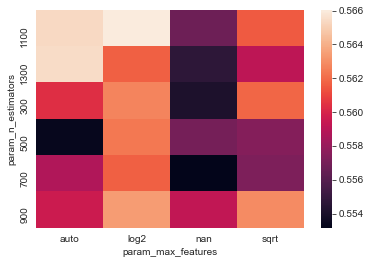

In [19]:
dt = pd.DataFrame(grid1.cv_results_)
dt.param_max_features = dt.param_max_features.astype(str)
dt.param_n_estimators = dt.param_n_estimators.astype(str)

table = pd.pivot_table(dt, values='mean_test_score', index='param_n_estimators', 
                       columns='param_max_features')
     
sns.heatmap(table)

In [20]:
grid1.best_score_

0.5660171733290359

In [21]:

param_grid2 = {'max_features':['auto'],
          'n_estimators':[1000, 1100, 1200],
           'criterion': ['entropy', 'gini'],    
          'max_depth': [7, 9, 11, 13, 15, None],
         }

rf_model = RandomForestClassifier()
grid2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2.fit(train_x, train_y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  3.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [7, 9, 11, 13, 15, None],
                         'max_features': ['auto'],
                         'n_estimators': [1000, 1100, 1200]},
             scoring='f1', verbose=1)

In [22]:
grid2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=1200)

<AxesSubplot:xlabel='param_criterion', ylabel='param_max_depth'>

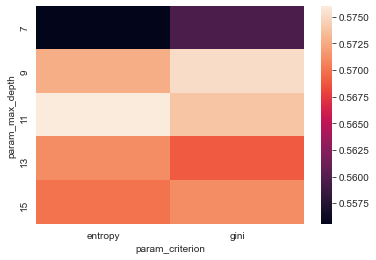

In [23]:
dt = pd.DataFrame(grid2.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_max_depth', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [24]:
grid2.best_score_

0.5771387926112501

In [25]:

param_grid2_2 = {'max_features':['auto'],
          'n_estimators':[950, 1000, 1050],
           'criterion': ['entropy'],    
          'max_depth': [10, 11, 12],
         }

rf_model = RandomForestClassifier()
grid2_2 = GridSearchCV(estimator=rf_model, param_grid=param_grid2_2, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid2_2.fit(train_x, train_y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   48.5s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10, 11, 12],
                         'max_features': ['auto'],
                         'n_estimators': [950, 1000, 1050]},
             scoring='f1', verbose=1)

In [26]:
grid2_2.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=1050)

In [27]:
grid2_2.best_score_

0.5775007090192678

In [28]:
param_grid3 = {'max_features':['auto'],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

rf_model = RandomForestClassifier()
grid3 = GridSearchCV(estimator=rf_model, param_grid=param_grid3, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid3.fit(train_x, train_y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [1000]},
             scoring='f1', verbose=1)

In [29]:

grid3.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       min_samples_split=6, n_estimators=1000)

<AxesSubplot:xlabel='param_min_samples_split', ylabel='param_min_samples_leaf'>

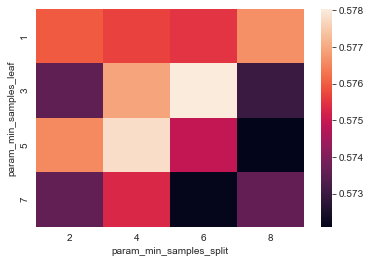

In [30]:
dt = pd.DataFrame(grid3.cv_results_)

table = pd.pivot_table(dt, values='mean_test_score', index='param_min_samples_leaf', 
                       columns='param_min_samples_split')
     
sns.heatmap(table)

In [31]:
grid3.best_score_

0.5780266718436863

In [32]:
param_grid4 = {'class_weight':[{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}],
            'max_features':['auto'],
          'n_estimators':[1000],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1],
          'min_samples_split': [8]
         }

rf_model = RandomForestClassifier()
grid4 = GridSearchCV(estimator=rf_model, param_grid=param_grid4, n_jobs=-1, cv=3, verbose=1, scoring = 'f1')
grid4.fit(train_x, train_y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   21.5s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   21.8s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [8], 'n_estimators': [1000]},
             scoring='f1', verbose=1)